In [146]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [147]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [148]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [149]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [150]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [151]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [152]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [153]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [154]:
#importing inspection function 
from sqlalchemy import inspect

#initializing inspector variable 
inspector = inspect(engine)
inspector.get_table_names()

#Finding table columns
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [155]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

('2017-08-23',)
Query Date:  2016-08-23


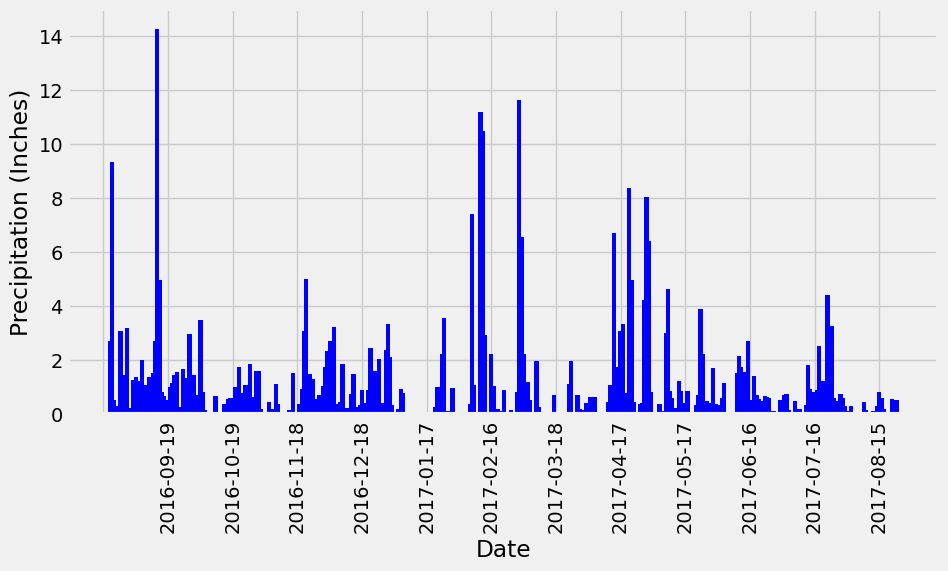

In [174]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
precipitation_date = session.query(Measurement.date, func.round(func.sum(Measurement.prcp), 2)).\
                     filter(Measurement.date >= query_date).\
                     group_by(Measurement.date).\
                     all()

#Creating Dataframe to store variable
precipitation_df = pd.DataFrame(precipitation_date, columns=['Date', 'Precipitation'])
precipitation_df.head(50)

# Sort the dataframe by date
sorted_df = precipitation_df.sort_values(by='Date')
sorted_df.head(50)

#Plot bar graph
fig, ax = plt.subplots(figsize=(10, 5)) 
ax = plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], color ='blue', 
        width = 2)

# Adjust x-axis date rotation so it appears vverticle
plt.xticks(rotation=90) 
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')

#Module to help manage date-time axises of a grpah
from matplotlib.dates import DayLocator

#Initilizaizes how often and wehre the x-tick should appear 30 days in this case
locator = DayLocator(interval=30)  
#plt.gca acccess the current properties of ax(bar graph) to manipulate x-tciks
plt.gca().xaxis.set_major_locator(locator)
plt.show()


In [157]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['Precipitation'].describe()
print(precipitation_summary)

count    366.000000
mean       0.978907
std        1.776349
min        0.000000
25%        0.052500
50%        0.405000
75%        1.087500
max       14.280000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [158]:
#importing inspection function 
from sqlalchemy import inspect

#initializing inspector variable 
inspector = inspect(engine)
inspector.get_table_names()

#Finding table columns
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [159]:
general = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
for x in general:
    print(x)

('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


In [160]:
# Design a query to calculate the total number of stations in the dataset
total_number_of_station = session.query(Station.station).group_by(Station.station).count()
total_number_of_station

9

In [161]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
#which station id has the greatest number of observations?

active_stations = session.query(Measurement.station, Station.name, func.count(Station.station)).\
                  filter(Measurement.station == Station.station).\
                  group_by(Station.station).\
                  order_by(func.count(Station.station).desc()).\
                  all()

print(f"Station {active_stations[0]} has the most nubmer of observations")



Station ('USC00519281', 'WAIHEE 837.5, HI US', 2772) has the most nubmer of observations


In [162]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

min_temperature = session.query(func.min(Measurement.tobs)).\
                  filter(Measurement.station == active_stations[0].station).\
                  scalar()

max_temperature = session.query(func.max(Measurement.tobs)).\
                   filter(Measurement.station == active_stations[0].station).\
                  scalar()

average_temperature = session.query(func.avg(Measurement.tobs)).\
                   filter(Measurement.station == active_stations[0].station).\
                  scalar()

print(f"The minimum temparture is {min_temperature}, the maximum temperature is {max_temperature}, and the average temeprature is {average_temperature}")



The minimum temparture is 54.0, the maximum temperature is 85.0, and the average temeprature is 71.66378066378067


('2017-08-18',)
Query Date:  2016-08-18


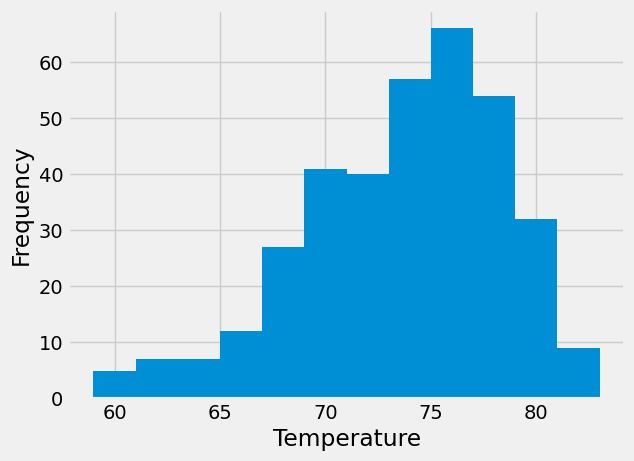

In [163]:
#finding out the latest date from the most active station
latest_date = session.query(Measurement.date).\
              filter(Measurement.station == active_stations[0].station).\
              order_by(Measurement.date.desc()).first()
print(latest_date)

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)
print("Query Date: ", query_date)

#Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query(Measurement.tobs).\
                           filter(Measurement.station == Station.station).\
                           filter(Measurement.date >= query_date).\
                           filter(Measurement.station == active_stations[0].station).\
                           all()

#Turning temperature into a dataframe
temperature_observations_df = pd.DataFrame(temperature_observations)

#plotting the graph
plt.hist(temperature_observations_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [164]:
# Close Session
session.close()